# Reinforcement Learning - Homework 3
Yifan WANG

In [179]:
import numpy as np
import lqg1d
from tqdm import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import utils


In [188]:
class ConstantStep(object):
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate

    def update(self, gt):
        return self.learning_rate * gt    

class AdamStep(object):
    def __init__(self, learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.reset()
        
    def reset(self):
        self.m = 0
        self.v = 0
        
    def update(self, gt):
        self.m = self.beta1 * self.m + (1-self.beta1) * gt
        self.v = self.beta2 * self.v + (1-self.beta2) * gt * gt
        m_hat = self.m/(1-self.beta1)
        v_hat = self.v/(1-self.beta2)
        return self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)
    
class AnnealStep(object):
    """ Applies exponential decay to the learning rate
    """
    def __init__(self, learning_rate, decay_steps, decay_rate):
        self.learning_rate = learning_rate
        self.decay_steps = decay_steps
        self.decay_rate = decay_rate
        self.steps = 0

    def update(self, gt):
        self.steps += 1
        lr = self.learning_rate * np.power(self.decay_rate, self.steps//self.decay_steps)
        return  lr * gt  

## Question 1

Implement REINFORCE with Gaussian policy model.

In [183]:
#####################################################
# Define the environment and the policy
#####################################################

class GaussianPolicy(object):
    def __init__(self, theta=None, sigma=None, deterministic=False):
        if theta is None:
            self.theta = 1- 2*np.random.random()
        else:
            self.theta = theta
        if sigma is None: 
            self.sigma = np.random.random()
        else:
            self.sigma = sigma
        self.deterministic = deterministic
    
    def draw_action(self, s):
        # 1-d
        if self.deterministic:
            a = self.theta * s
        else:
            a = np.random.normal(self.theta * s, self.sigma)
        return a
    
    def gradient(self, a, s):
        """ Compute the gradients w.r.t theta (not sigma here)
        """
        mu = self.theta*s
        grad_theta = (a-mu)/(self.sigma**2) * s
        # grad_sigma = ((a-mu)**2 - self.sigma**2)/np.power(self.sigma, 3)
        return grad_theta, None

        
    def update(self, delta_theta, delta_sigma):
        self.theta += delta_theta
        self.sigma += delta_sigma
        
def discount_reward(rewards, gamma):
    re = 0
    for r in rewards[::-1]:
        re = (re + r) * gamma 
    return re / gamma
        
def REINFORCE(env, policy, stepper, n_itr, N, T, discount, N_eval):
    """
    REINFORCE algorithm that only update theta
    Args:
        env: enviroment
        policy: policy class
        n_itr: number of iterations in gradient descent
        N: number of episodes used to estimate the gradient in each iteration
        discount: discount factor
        N_eval: number of episodes used to estimate the performance
    """
    mean_parameters = []
    avg_return = []

    for _ in range(n_itr)):
        paths = utils.collect_episodes(env, policy=policy, horizon=T, n_episodes=N)
        grads_theta = []
    
        for d in paths:
            # estimate gradient
            R = discount_reward(d['rewards'], discount)
            grad_theta = 0
            for a, s in zip(d['actions'], d['states']):
                g_theta, _ = policy.gradient(a, s)
                grad_theta += g_theta
            grads_theta.append(grad_theta*R)

        grad_theta = np.mean(grads_theta)
        delta_theta = stepper.update(grad_theta)

        policy.update(delta_theta, 0)
    
        J = utils.estimate_performance(env, policy=policy, horizon=T, n_episodes=N_eval, gamma=discount)
        avg_return.append(J)
        mean_parameters.append(policy.theta)
    return mean_parameters, avg_return

We start considering the case of ﬁxed standard deviation σ ω (s) = 0.5. The only parameter to learn is the parametrization of the mean µ = θs

In [201]:
# Constant step
env = lqg1d.LQG1D(initial_state_type='random')
policy = GaussianPolicy(sigma=0.5)
learning_rate = 0.0001
stepper = ConstantStep(learning_rate)
mean_parameters, avg_return = REINFORCE(env, policy, stepper, n_itr=100, N=100, T=100, discount=0.9, N_eval=100)

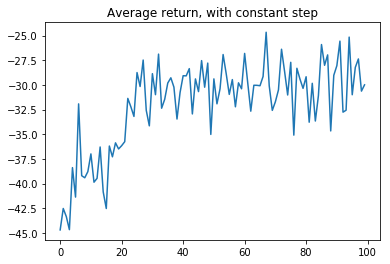

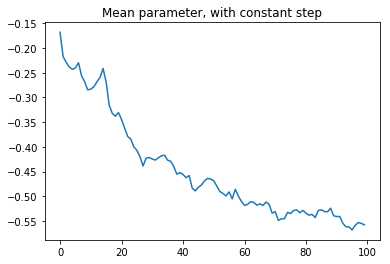

In [202]:
plt.figure()
plt.plot(avg_return)
plt.title("Average return, with constant step")
plt.show()
plt.figure()
plt.plot(mean_parameters)
plt.title("Mean parameter, with constant step")
plt.show()

In [203]:
# Annealing step
policy = GaussianPolicy(sigma=0.5)
learning_rate = 0.0001
stepper = AnnealStep(learning_rate=learning_rate, decay_steps=10, decay_rate=0.98)
mean_parameters, avg_return = REINFORCE(env, policy, stepper, n_itr=100, N=100, T=100, discount=0.9, N_eval=100)

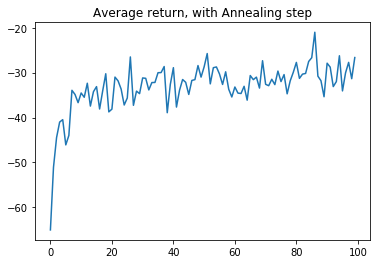

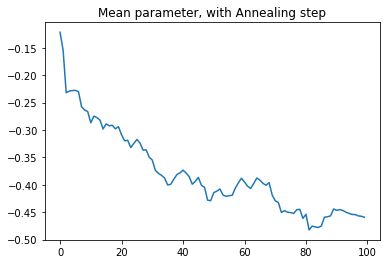

In [204]:
plt.figure()
plt.plot(avg_return)
plt.title("Average return, with Annealing step")
plt.show()
plt.figure()
plt.plot(mean_parameters)
plt.title("Mean parameter, with Annealing step")
plt.show()

In [205]:
# Adam step
policy = GaussianPolicy(sigma=0.5)
learning_rate = 0.01
stepper = AdamStep(learning_rate)
mean_parameters, avg_return = REINFORCE(env, policy, stepper, n_itr=100, N=100, T=100, discount=0.9, N_eval=100)

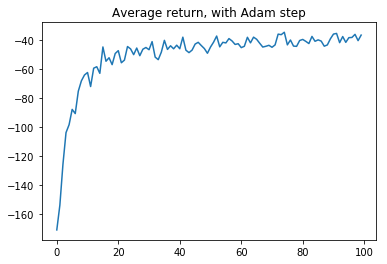

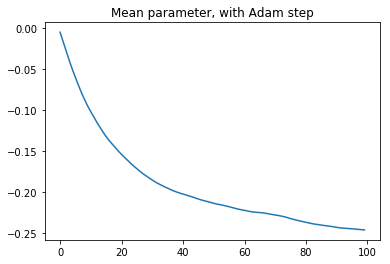

In [206]:
plt.figure()
plt.plot(avg_return)
plt.title("Average return, with Adam step")
plt.show()
plt.figure()
plt.plot(mean_parameters)
plt.title("Mean parameter, with Adam step")
plt.show()

We found that the Adam method is the most stable one, while the constant step gradient descent is the least stable one. Annealing step can help reduce variance after some iterations. However, Adam seems to converge a little bit more slowly than the other two, since it adjusts the gradient.

## Play with parameters
### N

$N$ influences the estimate of gradients, a small $N$ will lead to a bad estimation of gradients and make the algorithm hard to converge.

In [212]:
# Adam step
policy = GaussianPolicy(sigma=0.5)
learning_rate = 0.01
stepper = AdamStep(learning_rate)
mean_parameters, avg_return = REINFORCE(env, policy, stepper, n_itr=100, N=10, T=100, discount=0.9, N_eval=100)

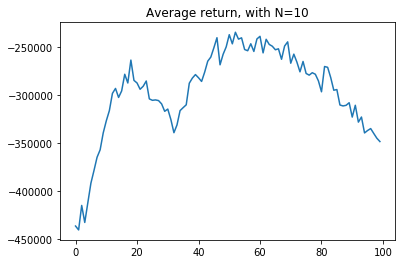

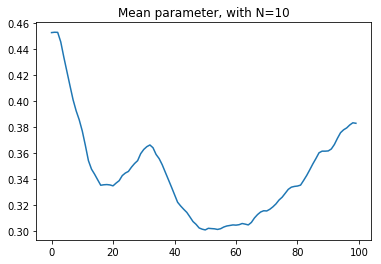

In [213]:
plt.figure()
plt.plot(avg_return)
plt.title("Average return, with N=10")
plt.show()
plt.figure()
plt.plot(mean_parameters)
plt.title("Mean parameter, with N=10")
plt.show()

In [210]:
# Adam step
policy = GaussianPolicy(sigma=0.5)
learning_rate = 0.01
stepper = AdamStep(learning_rate)
mean_parameters, avg_return = REINFORCE(env, policy, stepper, n_itr=100, N=5, T=100, discount=0.9, N_eval=100)

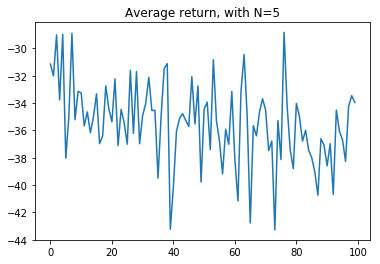

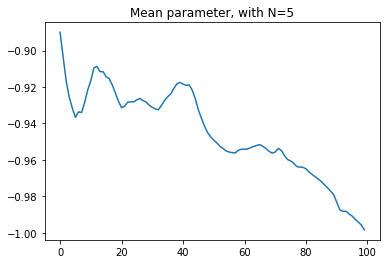

In [211]:
plt.figure()
plt.plot(avg_return)
plt.title("Average return, with N=5")
plt.show()
plt.figure()
plt.plot(mean_parameters)
plt.title("Mean parameter, with N=5")
plt.show()

### T
A small $T$, can similarly lead to a bad estimation of the gradients, and make the algorithm hard to converge.

In [218]:
# Adam step
policy = GaussianPolicy(sigma=0.5)
learning_rate = 0.01
stepper = AdamStep(learning_rate)
mean_parameters, avg_return = REINFORCE(env, policy, stepper, n_itr=100, N=100, T=10, discount=0.9, N_eval=100)

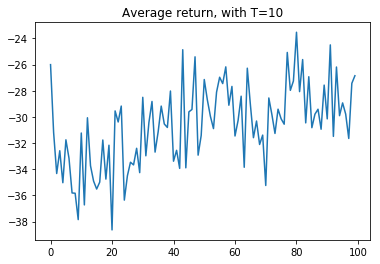

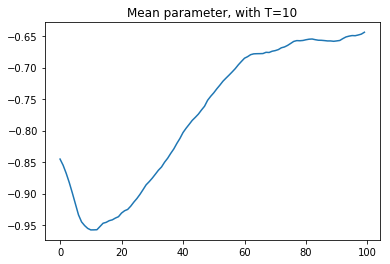

In [219]:
plt.figure()
plt.plot(avg_return)
plt.title("Average return, with T=10")
plt.show()
plt.figure()
plt.plot(mean_parameters)
plt.title("Mean parameter, with T=10")
plt.show()

### $\sigma_{\omega}$
A small $\sigma_{\omega}$ leads to less exploration but more exploitation, both being too small or being to big is not good for the algorithm to converge.

In [220]:
# Adam step
policy = GaussianPolicy(sigma=0.01)
learning_rate = 0.01
stepper = AdamStep(learning_rate)
mean_parameters, avg_return = REINFORCE(env, policy, stepper, n_itr=100, N=100, T=100, discount=0.9, N_eval=100)

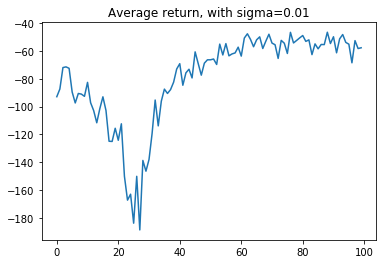

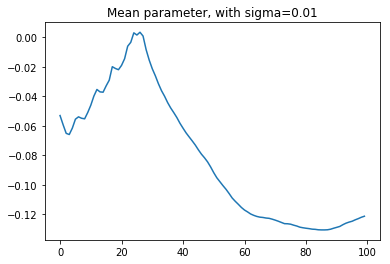

In [221]:
plt.figure()
plt.plot(avg_return)
plt.title("Average return, with sigma=0.01")
plt.show()
plt.figure()
plt.plot(mean_parameters)
plt.title("Mean parameter, with sigma=0.01")
plt.show()

In [224]:
# Adam step
policy = GaussianPolicy(sigma=10)
learning_rate = 0.01
stepper = AdamStep(learning_rate)
mean_parameters, avg_return = REINFORCE(env, policy, stepper, n_itr=100, N=100, T=100, discount=0.9, N_eval=100)

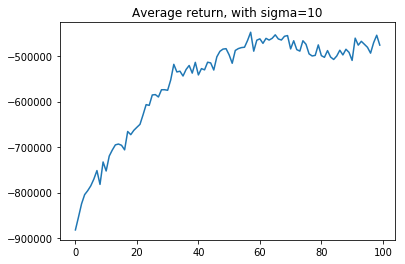

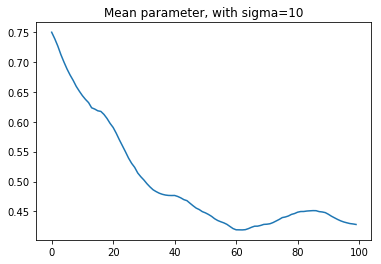

In [225]:
plt.figure()
plt.plot(avg_return)
plt.title("Average return, with sigma=10")
plt.show()
plt.figure()
plt.plot(mean_parameters)
plt.title("Mean parameter, with sigma=10")
plt.show()

### Can you explain a little bit the eﬀect of the parameters $\alpha_t$ (in the case of standard update rule (1)) and N?

$\alpha_t$ is the learning rate, it influences the speed of convergence. If $\alpha_t$ is too small, the convergence will be stable, but very slow; if it's too big, the convergence might converge faster, but it can also be very unstable.

$N$ is the number of episodes used to estimate the gradients. A big $N$ can reduce the variance of the estimation of gradients, and lead to a better convergence. However, a big $N$ is expensive, since the time consumed is proportional to $N$. So it's a time-performance trade-off.

## Question 2
Compare the performance of the algorithm with diﬀerent values of N. For example try to use stochastic gradient ascent (N = 1) and much higher values.
### N = 1

In [227]:
print(env.computeOptimalK(gamma=.9))

[[-0.58840335]]


In [228]:
returns = []
learning_rate = 0.01
stepper = AdamStep(learning_rate)
for i in range(5):
    policy = GaussianPolicy(sigma=0.5, deterministic=True)
    stepper.reset()
    _, avg_return = REINFORCE(env, policy, stepper, n_itr=100, N=1, T=100, discount=0.9, N_eval=100)
    returns.append(avg_return[-1])

In [229]:
print("Average return (N=1):", np.mean(returns))

Average return (N=1): -357294.597622


### N = 10

In [235]:
returns = []
learning_rate = 0.01
stepper = AdamStep(learning_rate)
for i in range(5):
    policy = GaussianPolicy(sigma=0.5, deterministic=True)
    stepper.reset()
    _, avg_return = REINFORCE(env, policy, stepper, n_itr=100, N=50, T=100, discount=0.9, N_eval=100)
    returns.append(avg_return[-1])

In [236]:
print("Average return (N=10):", np.mean(returns))

Average return (N=10): -144817.093017


In [ ]:
returns = []
learning_rate = 0.01
stepper = AdamStep(learning_rate)
for i in range(5):
    policy = GaussianPolicy(sigma=0.5, deterministic=True)
    stepper.reset()
    _, avg_return = REINFORCE(env, policy, stepper, n_itr=100, N=200, T=100, discount=0.9, N_eval=100)
    returns.append(avg_return[-1])

A big $N$ can reduce the variance of the estimation of gradients, and lead to a better convergence. When $N=1$, the algorithm is very unstable. When $N$ becomes larger, the performance is improved.

## Question 3

Optimal K: [[-0.58840335]] Covariance S: 0.001


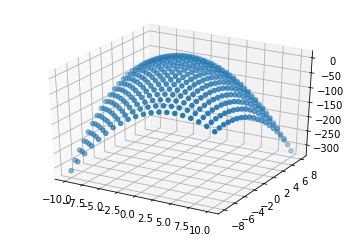

In [237]:
# ################################################################
# # Show the optimal Q-function
# #################################################################
def make_grid(x, y):
    m = np.meshgrid(x, y, copy=False, indexing='ij')
    return np.vstack(m).reshape(2, -1).T

states = discrete_states = np.linspace(-10, 10, 20)
SA = make_grid(states, actions)
S, A = SA[:, 0], SA[:, 1]

K, cov = env.computeOptimalK(discount), 0.001
print('Optimal K: {} Covariance S: {}'.format(K, cov))

Q_fun_ = np.vectorize(lambda s, a: env.computeQFunction(s, a, K, cov, discount, 1))
Q_fun = lambda X: Q_fun_(X[:, 0], X[:, 1])

Q_opt = Q_fun(SA)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(S, A, Q_opt)

plt.show()

In [238]:
#################################################################
# Collect the samples using the behavioural policy
#################################################################


class BehaviouralPolicy(object):
    """
    Behavioural policy that selects actions in A with uniform probability.
    """
    def __init__(self, actions):
        self.actions = actions
        
    def draw_action(self, s):
        # TODO
        return np.random.choice(self.actions)

    

class LinearFQIPolicy(object):
    """Linear approximation of Q value function with features 
    corresponding to a second-order polynomial in (s, a).
    """
    def __init__(self, dataset, action_space, discount, lam):
        self.action_space = action_space
        self.discount = discount
        self.lam = lam
        self.theta = np.random.random((3,1))
        self.n_ep = len(dataset)
        self.T = dataset[0]['states'].shape[0]
        self.states = np.zeros(self.T * self.n_ep)
        self.actions = np.zeros(self.T * self.n_ep)
        self.rewards = np.zeros(self.T * self.n_ep)
        self.next_states = np.zeros(self.T * self.n_ep)
        # features
        self.Z = np.zeros((self.T * self.n_ep, 3))
        for i in range(self.n_ep):
            actions = dataset[i]['actions']
            states = dataset[i]['states']
            rewards = dataset[i]['rewards']
            next_states = dataset[i]['next_states']
            for t in range(self.T):
                a = actions[t]
                s = states[t]
                self.Z[i*self.T + t, :] = self.feature(s, a).reshape(-1)
                self.states[i*self.T + t] = states[t]
                self.actions[i*self.T + t] = actions[t]
                self.rewards[i*self.T + t] = rewards[t]
                self.next_states[i*self.T + t] = next_states[t]
    
    def feature(self, s, a):
        return np.asarray([a, s*a, s**2 + a **2]).reshape((-1, 1))
    
    def Q(self, s, a):
        return np.asarray([a, s*a, s**2 + a **2]).reshape(1,-1).dot(self.theta)
    
    def bellman(self, s, a, r, s2):
        """Empirical Bellman optimal operato
        """
        Qs = [self.Q(s2, act) for act in self.actions]
        return r + self.discount * np.max(Qs)
        
    def update(self):
        y = np.zeros((self.T * self.n_ep, 1))
        for i in range(self.T * self.n_ep):
            y[i] = self.bellman(self.states[i], self.actions[i],
                               self.rewards[i], self.next_states[i])
            
        self.theta = np.linalg.inv(self.Z.T.dot(self.Z) + self.lam * np.eye(3)).dot(self.Z.T).dot(y)
            
    def draw_action(self, s):
        rewards = []
        for a in self.action_space:
            rewards.append(self.Q(s, a))
        return self.action_space[np.argmax(rewards)]

In [239]:
actions = discrete_actions = np.linspace(-8, 8, 20)
# You should use discrete actions
beh_policy = BehaviouralPolicy(actions)

dataset = utils.collect_episodes(env, n_episodes=50,
                                            policy=beh_policy, horizon=50)
fqi = LinearFQIPolicy(dataset=dataset, action_space=actions, discount=0.9, lam=0.01)
Js = []
for i in range(10):
    fqi.update()
    J = utils.estimate_performance(env, policy=fqi, horizon=50, n_episodes=50, gamma=0.9)
    Js.append(J)
    print('Policy performance: {}'.format(J))

Policy performance: -51178.322923794825
Policy performance: -55.065643405151974
Policy performance: -29.677470614476665
Policy performance: -20.785604392599776
Policy performance: -23.44860305045589
Policy performance: -28.378156721788006
Policy performance: -30.360421710134464
Policy performance: -31.567017975888678
Policy performance: -27.539435653771488
Policy performance: -20.80493047703753


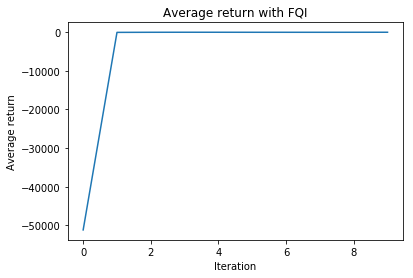

In [245]:
plt.figure()
plt.plot(range(10), Js)
plt.title("Average return with FQI")
plt.xlabel("Iteration")
plt.ylabel("Average return")
plt.show()

The experiment shows that FQI can converge faster than parametric Gaussian policy gradient, and seems to be more stable.

Optimal K: [[-0.58840335]] Covariance S: 0.001


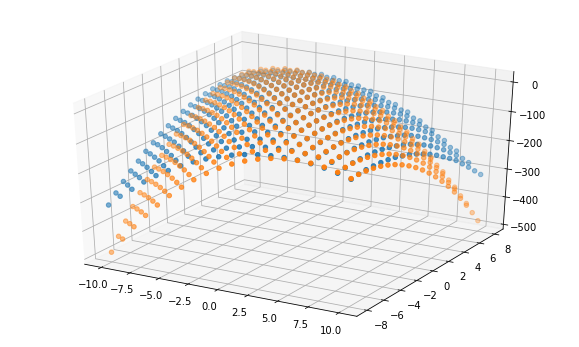

In [246]:
def make_grid(x, y):
    m = np.meshgrid(x, y, copy=False, indexing='ij')
    return np.vstack(m).reshape(2, -1).T

states = discrete_states = np.linspace(-10, 10, 20)
SA = make_grid(states, actions)
S, A = SA[:, 0], SA[:, 1]

K, cov = env.computeOptimalK(discount), 0.001
print('Optimal K: {} Covariance S: {}'.format(K, cov))

Q_fun_ = np.vectorize(lambda s, a: env.computeQFunction(s, a, K, cov, discount, 1))
Q_fun = lambda X: Q_fun_(X[:, 0], X[:, 1])
Q_opt = Q_fun(SA)

Q_fun2_ = np.vectorize(lambda s, a: fqi.Q(s, a))
Q_fun2 = lambda X: Q_fun2_(X[:, 0], X[:, 1])
Q_opt2 = Q_fun2(SA)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(S, A, Q_opt)

# ax2 = fig.add_subplot(212, projection='3d')
ax.scatter(S, A, Q_opt2)
plt.show()

The approximated Q-value function is quite closr to the optimal one.